# Basic Analyses:
  
To-DO: 
- decide which subjects to exclude. 

- replot the regression coefficients. 
- correlate intercept model parameters across sessions 
- read in the stai data.

In [1]:
import subprocess
label = subprocess.check_output(["git", "rev-parse","--verify","HEAD"]).strip()
print('GIT SHA: '+str(label))

GIT SHA: 4a3cfa078eb34c6be47f0194a0c1556407919286


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
import scipy.stats as ss


In [3]:
import sys
sys.path.append("../functions/")
#for data preprocessing
import Scripts_Data_Processing
import imp

imp.reload(Scripts_Data_Processing)
from Scripts_Data_Processing import *
#for model fit
import Scripts_LogRegModels_v2
imp.reload(Scripts_LogRegModels_v2)
from Scripts_LogRegModels_v2 import *

import NoBrainer_Analysis_AllinOne
imp.reload( NoBrainer_Analysis_AllinOne)
from  NoBrainer_Analysis_AllinOne import *

import Triplets_Correlations_Scatterplots
imp.reload( Triplets_Correlations_Scatterplots)
from  Triplets_Correlations_Scatterplots import *

import Plot_models
imp.reload(Plot_models)
from Plot_models import *

# read in data + nobrainer

## gainloss

In [4]:
df_list = []
vp_perform_gainloss_list = []
vp_nb_gainloss_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '40']
for vp in vp_list:
    path = os.path.join(os.getcwd(),'..','data','data_gainloss_logfiles','vp' + vp + '_gainloss_processed.csv')
    df = pd.read_csv(path, sep=",")
    #preprocess gainloss data
    df=preprocess_gainloss(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_gainloss(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_gainloss = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_gainloss_list.append(vp_perform_gainloss)
    #vp performance sectionwise
    vp_nb_gainloss = nb_df.groupby('section').mean().add_prefix('gainloss_')[['gainloss_choseBetter']]
    vp_nb_gainloss['MID'] = 'vp'+ vp
    vp_nb_gainloss_list.append(vp_nb_gainloss)
    
#make dataframe for nb performance
nobrainer_gainloss = pd.DataFrame(vp_perform_gainloss_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
gainloss_ls_df = df


C:\Users\Hanna\Anaconda2\lib\site-packages\pandas\core\indexing.py:288: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Hanna\Anaconda2\lib\site-packages\pandas\core\indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [5]:
#Merge dataframe list to single dataframe. "inner": Just take columns which exist in all dataframes    
gainloss_df = pd.concat(df_list, ignore_index = True, join = 'inner')  

In [6]:
nobrainer_gainloss

,MID,nbperf
0,vp06,0.941176
1,vp07,0.970588
2,vp10,1.000000
3,vp11,0.970588
4,vp12,0.941176
5,vp13,0.911765
6,vp15,0.941176
7,vp16,0.970588
8,vp17,0.970588
9,vp18,0.941176


## shock

In [7]:
df_list = []
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
vp_perform_shock_list = []
vp_nb_shock_list = []
section_list = ['1', '2', '3']
for vp in vp_list:
    df = []
    for sec in section_list:
        path = os.path.join(os.getcwd(),'..','data','data_shock_logfiles','Expt1Pain_Behaviour_vp' + vp + '_' + sec + '.txt')
        df_dummy = pd.read_csv(path, sep="\t", skiprows = [0])
        df_dummy = df_dummy[:-1] #deletes last row of each section as it does not contain trial data
        df_dummy['MID'] = 'vp'+ vp
        df_dummy['section'] = sec
        df_dummy.columns = df_dummy.columns.str.replace(' ','')
        df.append(df_dummy)
    
    #create a df that contains data from all sections    
    df = pd.concat(df, ignore_index = True, join = 'inner')
    #preprocess shock data
    df = preprocess_shock(df)
    #preprocess data
    df = preprocess(df)
    #store prepocessed data in list that contains data for all subjects (for later analysis)
    df_list.append(df)
    #create subset with unambiguous trials for no brainer analysis
    nb_df = drop_ambi_trials(df)
    #create variables indicating whether left or right was the better option
    better_choice_shock(nb_df)
    #indicate whether the better box was chosen
    nb_df = right_choice(nb_df)
    #only keep trials that are 'no brainers'
    nb_df = keep_nobrainers(nb_df)
    #calculate performance
    vp_perform_shock = ['vp' + vp, vp_perf(nb_df)]
    #store each vp performance in list
    vp_perform_shock_list.append(vp_perform_shock)
    #vp performance sectionwise
    vp_nb_shock = nb_df.groupby('section').mean().add_prefix('shock_')[['shock_choseBetter']]
    vp_nb_shock['MID'] = 'vp'+ vp
    vp_nb_shock_list.append(vp_nb_shock)
    
#make dataframe for nb performance
nobrainer_shock = pd.DataFrame(vp_perform_shock_list,columns=['MID','nbperf'])

#dataframe for single subject (last one) to try out code
shock_ls_df = df

../functions/NoBrainer_Analysis_AllinOne.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['left_better']=lb
../functions/NoBrainer_Analysis_AllinOne.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['right_better']=rb


In [8]:
#create complete df for shock condition with all vps        
shock_df = pd.concat(df_list, ignore_index = True, join = 'inner')

In [9]:
nobrainer_shock

,MID,nbperf
0,vp06,0.882353
1,vp07,1.000000
2,vp10,1.000000
3,vp11,1.000000
4,vp12,0.941176
5,vp13,1.000000
6,vp15,0.941176
7,vp16,1.000000
8,vp17,1.000000
9,vp18,1.000000


# Model fit - individual subjects

In [10]:
param_sets_split = {}
param_sets_split['0'] = ['mag_diff','prob_diff']
param_sets_split['1'] = ['mag_diff','prob_diff','ambiguityLevel']

## gainloss

In [12]:
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23_2', '25_2', '26_2', '27_2', '28_2', '29', '30', '32', '33', '34', '35', '36', '37', '38', '39', '40']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue']
model_param_df = np.array(['','','',3.0,3.0])
model_summary_df = nobrainer_gainloss

for vp in vp_list:
    
    df = gainloss_df[gainloss_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_gain','ambig_loss','unambig_gain','unambig_loss']:
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
            
        # Fit a model to each set of trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se=out['se']
        for param in params.index:
            paramn = param.replace('_loss','')
            paramn = paramn.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta','se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_gainloss = model_param_df
model_summary_gainloss_df = model_summary_df



In [ ]:
#print(out['aic'])
#print(out['pred_acc'])
#print(out['modelname'])
#out['results'].summary()

## shock

In [13]:
vp_list = ['06', '07', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '22', '23', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40']
resultnames = ['bic','aic','pseudoR2','pred_acc', 'llr_pvalue'] 
model_param_df = np.array(['','','',3.0, 3.0])
model_summary_df = nobrainer_shock

for vp in vp_list:
    
    df = shock_df[shock_df.MID == 'vp' + vp]
    MID = 'vp' + vp
        
    for split in ['ambig_shock','unambig_shock']:
        #print(split)
        if 'unambig' in split:
            paramnum='0'
        else:
            paramnum='1'
        # Fit a model to the ambiguous gain trials 
        out = fit_model_split_amb_unamb_gain_loss(df, whichreturn= split, params=param_sets_split[paramnum],zscore=True)
        
    
        modelname = out['modelname']

        for result in resultnames:
            model_summary_df.loc[(model_summary_df.MID== 'vp' + vp),result+'_'+split]=out[result]

        params = out['params']
        se = out['se']
        for param in params.index:
            paramn = param.replace('_gain','')
            paramn = paramn.replace('_amb','')
            paramn = paramn.replace('_rl','')
            row = np.array([MID,paramn,split,params[param],se[param]])
            model_param_df=np.vstack((model_param_df,row))

model_param_df = pd.DataFrame(model_param_df,columns=['MID','parameter','split','beta', 'se'])
model_param_df.drop(0,inplace=True) #df.index[0]
model_param_df['beta']=model_param_df['beta'].astype('float')
model_param_df_shock = model_param_df        
model_summary_shock_df = model_summary_df
   

### scatterplots for model fit and significance

#### gainloss

C:\Users\Hanna\Anaconda2\lib\site-packages\matplotlib\axes\_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


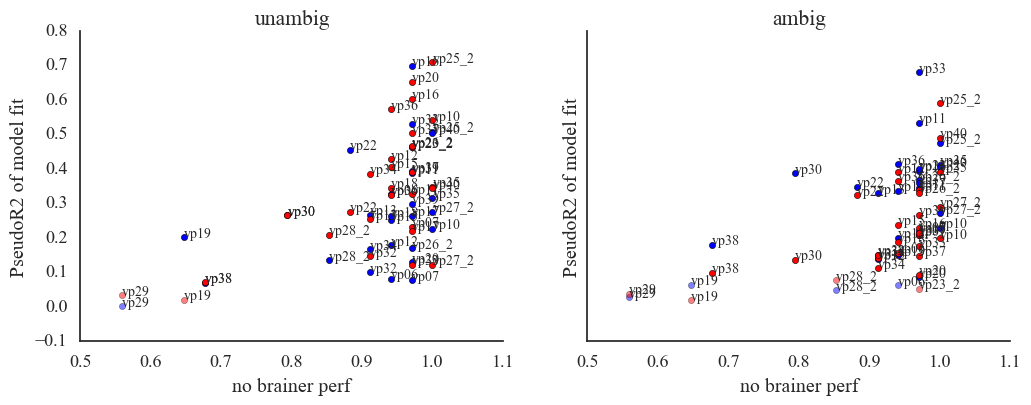

In [14]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_gainloss_df.MID
NB = model_summary_gainloss_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['gain','loss']:
        R2 = model_summary_gainloss_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_gainloss_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'
        plt.legend()

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
            #plt.legend()
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)

sns.despine()
#plt.legend()



#### shock

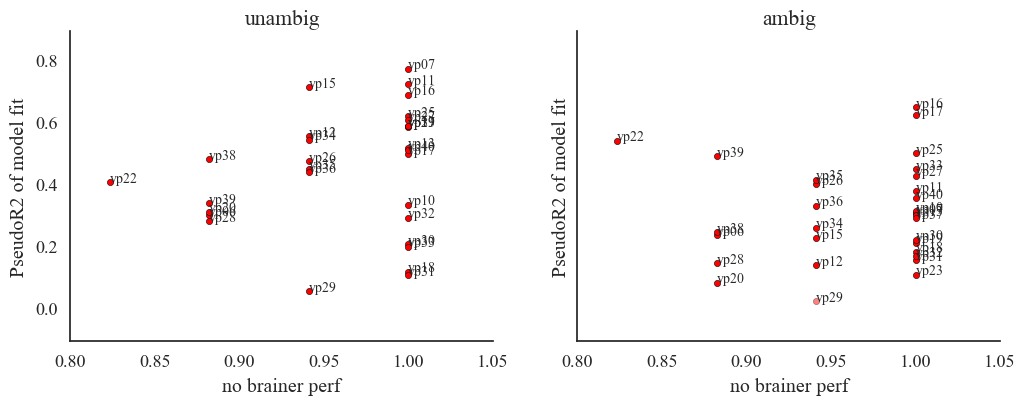

In [15]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
matplotlib.rc("font", family="Times New Roman")
sns.set_context('talk')
fig,axes =plt.subplots(1,2, figsize=(12,4),sharey=True,sharex=True)

MIDS = model_summary_shock_df.MID
NB = model_summary_shock_df['nbperf']
for tt,trial_type in enumerate(['unambig','ambig']):
    for task in ['shock']:
        R2 = model_summary_shock_df['pseudoR2_'+trial_type+'_'+task]
        pvals = model_summary_shock_df['llr_pvalue_'+trial_type+'_'+task]
        color ='b' if task=='gain' else 'r'

        for r,n,p,mid in zip(R2,NB,pvals,MIDS):
            alpha=1.0 if p<0.05 else 0.5
            axes[tt].scatter(n,r, c=color,alpha=alpha)
            axes[tt].annotate(mid,(n,r),fontsize=10)
    axes[tt].set_xlabel('no brainer perf')
    axes[tt].set_ylabel('PseudoR2 of model fit')
    axes[tt].set_title(trial_type)
sns.despine()
plt.legend()

- what the hell is going on with the subjects that have .95 no brainer and <0.1 R2. 


### bargraph for parameters

In [16]:
# dataframe for gainloss and shock to plot in one graph
model_param_df = pd.concat([model_param_df_gainloss, model_param_df_shock])

In [17]:
# reverse beta parameters for shock and loss to match gain
model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'mag_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_shock')& (model_param_df.parameter == 'mag_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'mag_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'mag_diff'),'beta']*-1

model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_shock') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_shock') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'ambig_loss') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'ambig_loss') & (model_param_df.parameter == 'prob_diff'),'beta']*-1
model_param_df.loc[(model_param_df.split == 'unambig_loss') & (model_param_df.parameter == 'prob_diff'), 'beta'] = model_param_df.loc[(model_param_df.split == 'unambig_loss') & (model_param_df.parameter == 'prob_diff'),'beta']*-1


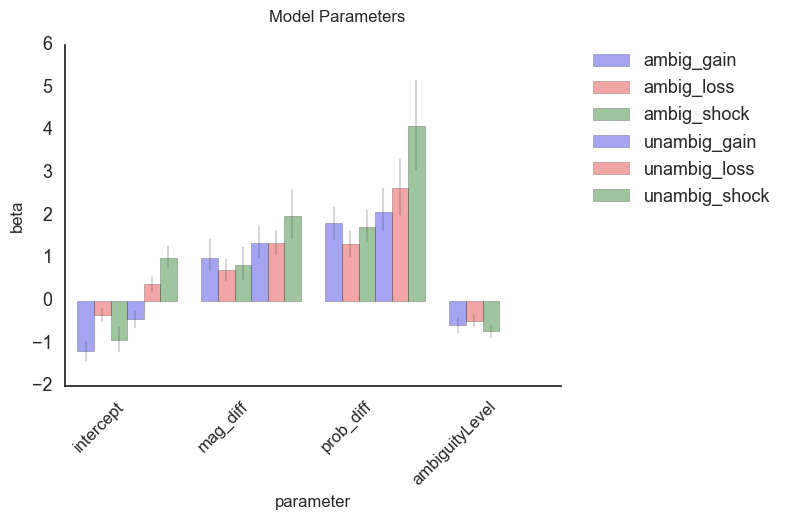

In [18]:
#plot bargraph
fig = plot_params(model_param_df, stripplot=False)

- remove bad fitting subjects - vp19 and vp29

In [19]:
print(len(model_param_df_shock))
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp29',]
model_param_df_shock = model_param_df_shock.loc[model_param_df_shock['MID']!='vp19',]
print(len(model_param_df_shock))

210
196


In [20]:
print(len(model_param_df_gainloss))
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp29',]
model_param_df_gainloss = model_param_df_gainloss.loc[model_param_df_gainloss['MID']!='vp19',]
print(len(model_param_df_gainloss))

406
378


In [21]:
print(len(model_param_df))
model_param_df = model_param_df.loc[model_param_df['MID']!='vp29',]
model_param_df = model_param_df.loc[model_param_df['MID']!='vp19',]
print(len(model_param_df))

616
574


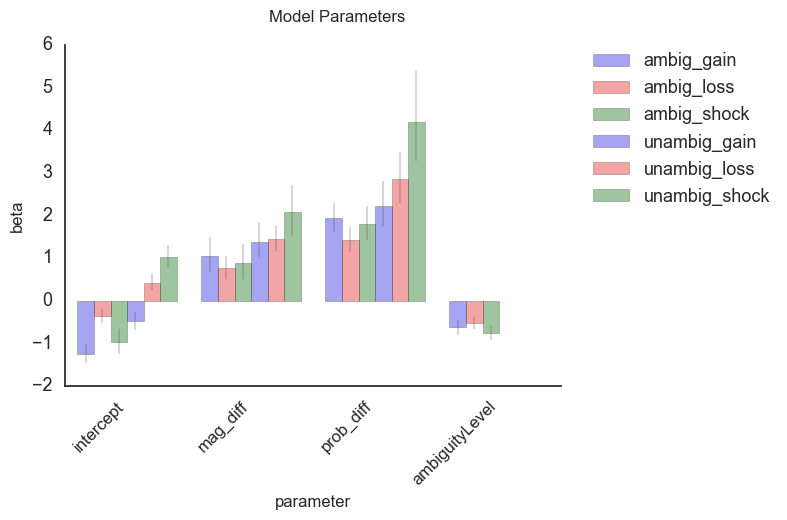

In [22]:
#bargraph without excluded subjects
fig = plot_params(model_param_df, stripplot=False)

# Plot individual parameter per task
- add x axis labels

In [23]:
#change MIDs to match between gainloss and shock versions
model_param_df.MID = model_param_df.MID.apply(lambda x: x.replace('_2', ''))

In [24]:
sns.set(style="ticks")
#model_param_df_merged = sns.load_dataset("model_param_df_merged")
#g = sns.factorplot(x="split", y="beta", col="parameter", row="MID", data=model_param_df)

# Triplet dataframe

## ambiguous trials

In [25]:
triplet_intercept = triplet(model_param_df, 'intercept', ambiguous=True)
triplet_magdiff = triplet(model_param_df, 'mag_diff', ambiguous=True)
triplet_probdiff = triplet(model_param_df, 'prob_diff', ambiguous=True)
triplet_ambiguityLevel = triplet(model_param_df, 'ambiguityLevel', ambiguous=True)

## unambiguous trials
- needs to be adjusted/completed in .py file

In [26]:
triplet_intercept_unambi = triplet(model_param_df, 'intercept', ambiguous=False)
triplet_magdiff_unambi = triplet(model_param_df, 'mag_diff', ambiguous=False)
triplet_probdiff_unambi = triplet(model_param_df, 'prob_diff', ambiguous=False)
triplet_ambiguityLevel_unambi = triplet(model_param_df, 'ambiguityLevel', ambiguous=False)

# subject count per order of task
-function need to go to a .py file

In [27]:
def count_order(triplet_df):

    triplet_df['order'] = np.nan

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] > triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gls'

    triplet_df.loc[(triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']) & (triplet_df['gain'] > triplet_df['shock']), 'order'] = 'gsl'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lgs'

    triplet_df.loc[(triplet_df['loss'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['shock']) & (triplet_df['loss'] > triplet_df['shock']), 'order'] = 'lsg'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] > triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'sgl'

    triplet_df.loc[(triplet_df['shock'] > triplet_df['gain']) & (triplet_df['gain'] < triplet_df['loss']) & (triplet_df['loss'] < triplet_df['shock']), 'order'] = 'slg'

    orderCount = pd.value_counts(triplet_df['order'])
    
    return(orderCount)

In [28]:
count_order(triplet_intercept)

lsg    11
lgs     9
slg     5
gls     2
Name: order, dtype: int64

In [29]:
count_order(triplet_probdiff)

sgl    10
gsl     6
gls     5
lgs     3
slg     2
lsg     1
Name: order, dtype: int64

In [30]:
count_order(triplet_magdiff)

gls    9
lsg    5
gsl    5
sgl    4
lgs    2
slg    2
Name: order, dtype: int64

In [31]:
count_order(triplet_ambiguityLevel)

gls    9
lsg    6
gsl    5
lgs    4
slg    2
sgl    1
Name: order, dtype: int64

In [32]:
triplet_probdiff.head()

,MID,gain,se_gain,loss,se_loss,shock,se_shock,order
0,vp06,0.618895,0.39654069989,0.171944,0.302125573416,1.654646,0.424077566921,sgl
1,vp07,1.156406,0.40292163675,1.251173,0.389190478561,1.871591,0.478225225102,slg
2,vp10,1.631189,0.447625740324,1.461982,0.403165070184,1.241292,0.429255250639,gls
3,vp11,4.201267,1.09595628298,2.184089,0.512258574857,2.164188,0.524700221893,gls
4,vp12,1.411448,0.427845850988,2.093028,0.496851595753,0.877154,0.35425932307,lgs


In [33]:
tableOrder = triplet_intercept.drop(triplet_intercept.columns[[1, 2, 3, 4, 5, 6]], axis=1)  # df.columns is zero-based pd.Index 


In [34]:
#table to plot counts
tableOrder = tableOrder.rename(columns={'order': 'intercept'})
tableOrder['prob_diff'] = triplet_probdiff['order']
tableOrder['mag_diff'] = triplet_magdiff['order']
tableOrder['ambiguityLevel'] = triplet_ambiguityLevel['order']
#table order should be long format
tableOrder = pd.melt(tableOrder, id_vars = 'MID', value_vars = ['intercept', 'prob_diff', 'mag_diff', 'ambiguityLevel'], var_name='parameter', value_name = 'order')

In [35]:
frame = tableOrder.groupby(['parameter', 'order'], as_index = False).count()
frame = frame.pivot(index='parameter', columns='order', values='MID')
frame = frame.fillna(0)
#frame = frame.as_matrix()
frame

order,gls,gsl,lgs,lsg,sgl,slg
parameter,,,,,,
ambiguityLevel,9.0,5.0,4.0,6.0,1.0,2.0
intercept,2.0,0.0,9.0,11.0,0.0,5.0
mag_diff,9.0,5.0,2.0,5.0,4.0,2.0
prob_diff,5.0,6.0,3.0,1.0,10.0,2.0


In [36]:
ss.chisquare(frame, f_exp=None, ddof=0, axis=1)

Power_divergenceResult(statistic=array([  9.22222222,  24.33333333,   7.44444444,  11.88888889]), pvalue=array([  1.00522051e-01,   1.87317623e-04,   1.89628338e-01,
         3.63423890e-02]))

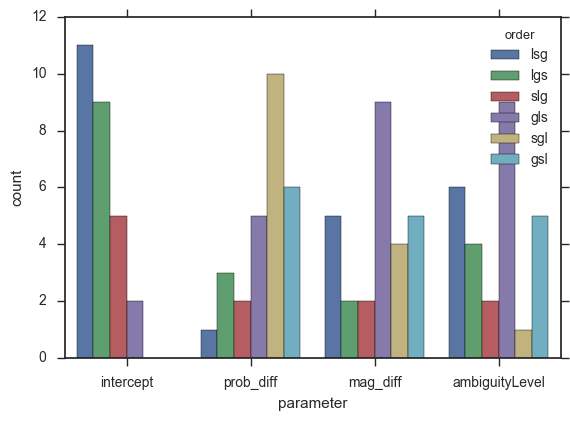

In [37]:
#plot counts
sns.countplot(x='parameter', hue='order', data=tableOrder)

# Traits (STAI)

## read in data and prepare dataframe

In [ ]:
#get data
#change directory to data folder
os.chdir("../data/")
cwd = os.getcwd()
xl = pd.ExcelFile('STAI.xlsx')
STAI_df = xl.parse('Data_Collection_Log')
STAI_df = STAI_df[['Subject ID', 'Session', 'STAI']]
STAI_df.columns = STAI_df.columns.str.replace(' ','')
STAI_df = STAI_df[STAI_df.SubjectID.str.contains("pilot") == False]
STAI_df = STAI_df.loc[STAI_df['Session'] == 1, :]

In [ ]:
#exclude subjects
vp_list = ['vp08', 'vp09', 'vp13' ,'vp14', 'vp21', 'vp24']

for vp in vp_list:
    
    STAI_df = STAI_df[STAI_df.SubjectID != vp]

In [ ]:
#change column name of key variable to match 
STAI_df = STAI_df.rename(columns={'SubjectID': 'MID'})

In [ ]:
triplet_intercept_STAI = triplet_intercept.merge(STAI_df, 'left')
triplet_probdiff_STAI = triplet_probdiff.merge(STAI_df, 'left')
triplet_magdiff_STAI = triplet_magdiff.merge(STAI_df, 'left')
triplet_ambiguityLevel_STAI = triplet_ambiguityLevel.merge(STAI_df, 'left')

## Plot STAI and Triplet (Ambiguous)

In [ ]:
def plotSTAI(triplet_df, param):
    #yerr = triplet_df['se_shock']
    #xerr = triplet_df['se_gain']
    fig,axes = plt.subplots(1,3, figsize = (12, 4),sharey=True,sharex=True)
    axes[0].scatter(triplet_df['STAI'],triplet_df['gain'])
    #axes[0].errorbar(triplet_df['gain'],triplet_df['shock'], xerr=xerr, yerr=yerr)
    axes[0].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[0].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)

    axes[0].set_xlabel('Trait Anxiety Score')
    axes[0].set_ylabel('beta')
    #axes[0].set_ylim([-3.5,3.5])
    axes[0].set_xlim([20,60])
    r,p=spearmanr(triplet_df['STAI'],triplet_df['gain'])
    axes[0].set_title('STAI/gain r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    
    #axes[0].set_aspect('equal')

    axes[1].scatter(triplet_df['STAI'],triplet_df['loss'])
    axes[1].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)
    axes[1].set_xlabel('Trait Anxiety Score')
    axes[1].set_ylabel('beta')
    r,p=spearmanr(triplet_df['STAI'],triplet_df['loss'])
    axes[1].set_title('STAI/loss r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[1].set_aspect('equal')

    axes[2].scatter(triplet_df['STAI'],triplet_df['shock'])
    axes[2].axhline(y=0.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].axvline(x=40.000,c="blue",linewidth=0.5,zorder=0)
    axes[2].set_xlabel('Trait Anxiety Score')
    axes[2].set_ylabel('beta')
    r,p=spearmanr(triplet_df['STAI'],triplet_df['shock'])
    axes[2].set_title('STAI/shock r={0} p={1}'.format(np.round(r,2),np.round(p,2)))
    #axes[2].set_aspect('equal')
    sns.despine()

    fig.suptitle(param)
    fig.subplots_adjust(top=0.77)
    


- why can't I set x axis limits?
- apparently it makes it so that both axes are of the same length, also true if figsize is not set

In [ ]:
plotSTAI(triplet_intercept_STAI, 'Ambiguity Presence')
plotSTAI(triplet_probdiff_STAI, 'ProbabilityDifference')
plotSTAI(triplet_magdiff_STAI, 'mag_diff')
plotSTAI(triplet_ambiguityLevel_STAI, 'ambiguityLevel')

In [ ]:
#triplet_probdiff_STAI

# Mean parameters per task (gain, loss, shock)

## Ambiguous Trials

### plot mean parameter per task with errorbars adjusted between gain, loss, and shock

In [38]:
#adjust errorbars
def adjErrTriplet(triplet_df):
    smean = triplet_df.mean(axis=1).values
    grandMean = sum(smean)/len(smean)
    triplet_df['shock'] = triplet_df['shock']-smean+grandMean
    triplet_df['gain'] = triplet_df['gain']-smean+grandMean
    triplet_df['loss'] = triplet_df['loss']-smean+grandMean
    return (triplet_df)

<Container object of 3 artists>

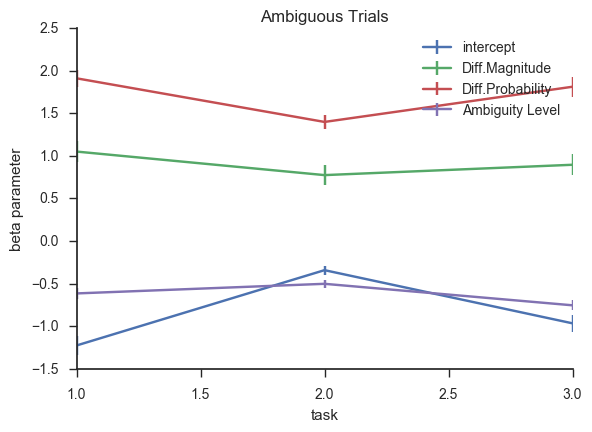

In [39]:
adjErrTriplet(triplet_intercept)
plotTripletAllSubs(triplet_intercept, 'intercept', 'Ambiguous Trials')
adjErrTriplet(triplet_magdiff)
plotTripletAllSubs(triplet_magdiff,'Diff.Magnitude','Ambiguous Trials')
adjErrTriplet(triplet_probdiff)
plotTripletAllSubs(triplet_probdiff,'Diff.Probability','Ambiguous Trials')
adjErrTriplet(triplet_ambiguityLevel)
plotTripletAllSubs(triplet_ambiguityLevel,'Ambiguity Level','Ambiguous Trials')

<Container object of 3 artists>

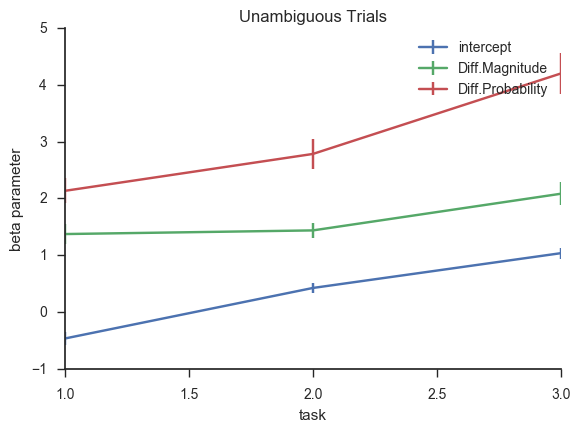

In [40]:
adjErrTriplet(triplet_intercept_unambi)
plotTripletAllSubs(triplet_intercept_unambi, 'intercept', 'Unambiguous Trials')
adjErrTriplet(triplet_magdiff_unambi)
plotTripletAllSubs(triplet_magdiff_unambi,'Diff.Magnitude','Unambiguous Trials')
adjErrTriplet(triplet_probdiff_unambi)
plotTripletAllSubs(triplet_probdiff_unambi,'Diff.Probability','Unambiguous Trials')
#adjErrTriplet(triplet_ambiguityLevel_unambi)
#plotTripletAllSubs(triplet_ambiguityLevel_unambi,'Ambiguity Level','Ambiguous Trials')

### plot scatterplot showing the spearman correlation (r and pvalue) of tasks for each parameter

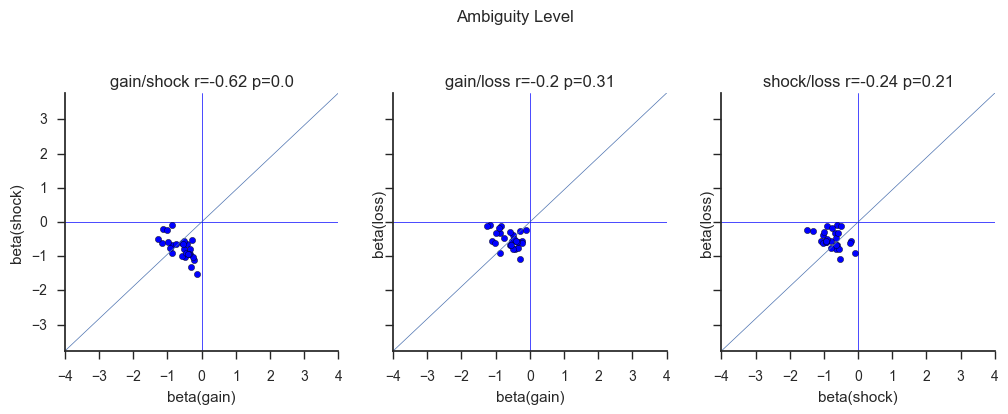

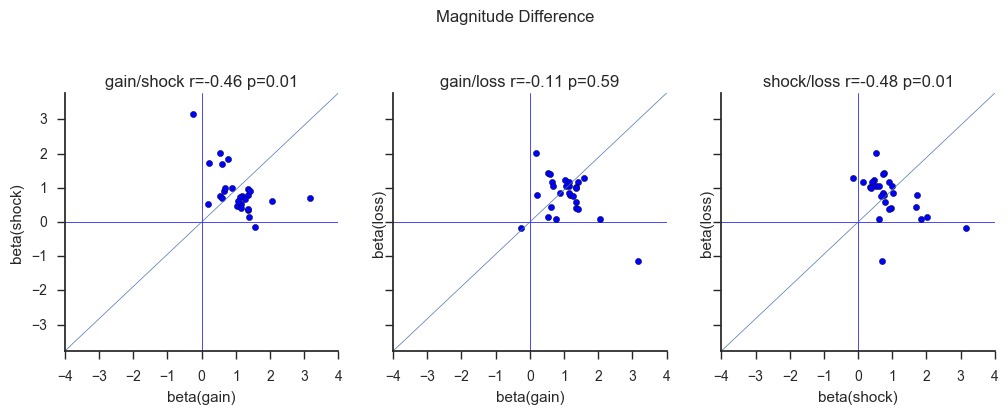

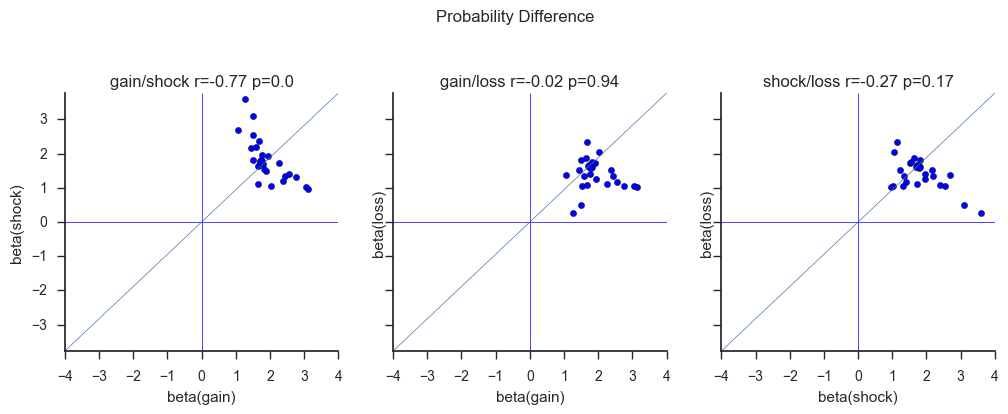

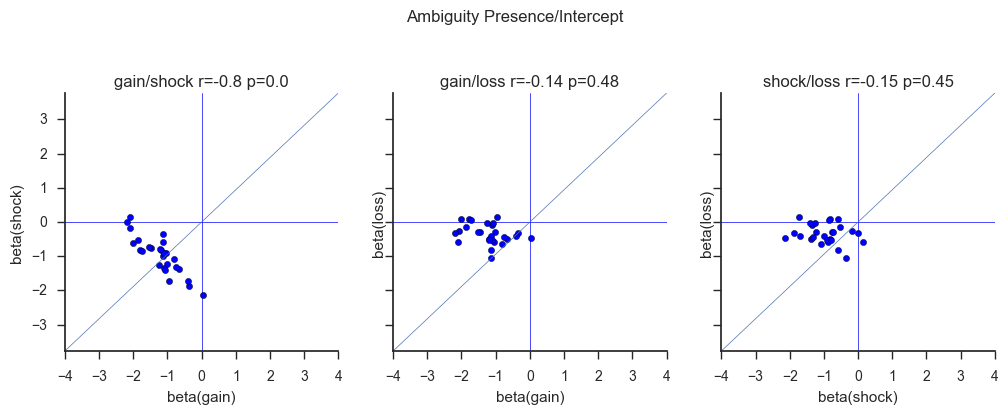

In [42]:
plotTriplet(triplet_ambiguityLevel, 'Ambiguity Level')
plotTriplet(triplet_magdiff, 'Magnitude Difference')
plotTriplet(triplet_probdiff, 'Probability Difference')
f=plotTriplet(triplet_intercept, 'Ambiguity Presence/Intercept')

#### correlation between magdiff and probdiff for every task

In [43]:
triplet_magdiff

,MID,gain,se_gain,loss,se_loss,shock,se_shock,order
0,vp06,0.526833,0.373872390106,1.430859,0.397230853501,0.762521,0.340973983094,lsg
1,vp07,1.395423,0.500751241075,1.167406,0.448858198922,0.157383,0.350742462653,gls
2,vp10,0.776911,0.471796507085,0.100462,0.350738826281,1.842839,0.607684259638,sgl
3,vp11,1.350840,0.570428761953,1.025042,0.455677006624,0.344330,0.361630378166,gls
4,vp12,0.875320,0.326222167367,0.837545,0.364067239233,1.007347,0.311961116926,sgl
5,vp13,1.027219,0.371510227865,1.221266,0.351103925664,0.471727,0.333461005008,lgs
6,vp15,1.187011,0.300999452458,0.778586,0.308330344047,0.754616,0.321908540456,gls
7,vp16,1.134033,0.371408478842,0.846396,0.313982927669,0.739783,0.539998302049,gls
8,vp17,0.647499,0.434771384462,1.175058,0.459401118695,0.897655,0.549959950479,lsg
9,vp18,0.222387,0.363747371708,0.780748,0.343782687546,1.717077,0.44872521146,slg


In [44]:
gain = triplet_magdiff.drop(triplet_magdiff.iloc[:, 2:8], axis = 1)
gain = gain.rename(columns={'gain': 'magdiff'})
gain['probdiff'] = triplet_probdiff['gain']


In [46]:
loss = triplet_magdiff.drop(triplet_magdiff.iloc[:,[1,2,4,5,6,7]], axis = 1)
loss = loss.rename(columns={'loss': 'magdiff'})
loss['probdiff'] = triplet_probdiff['loss']


In [49]:
shock = triplet_magdiff.drop(triplet_magdiff.iloc[:, [1,2,3,4,6, 7]], axis = 1)
shock = shock.rename(columns={'shock': 'magdiff'})
shock['probdiff'] = triplet_probdiff['shock']


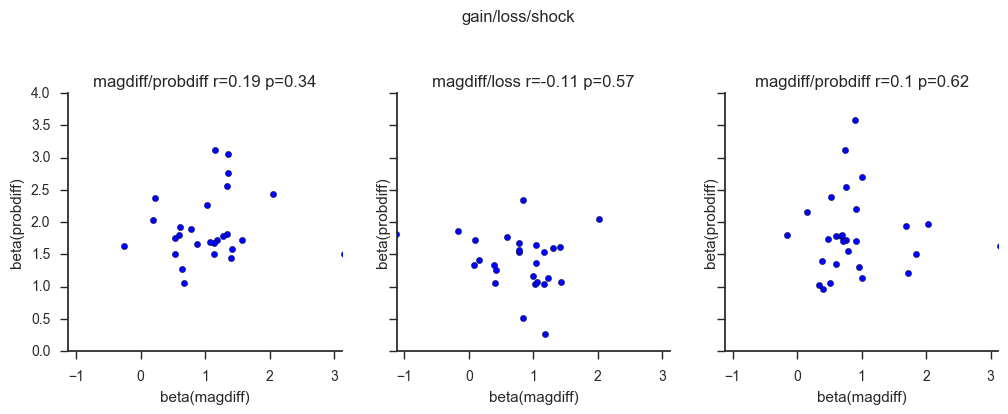

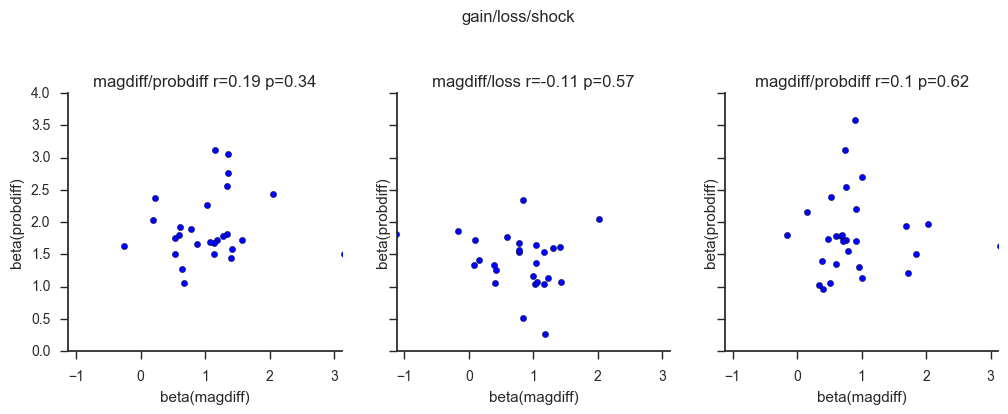

In [52]:
plotTriplet_task(gain, loss, shock)

# Statistics

## prepare dataframe

In [53]:
model_param_df['condition'] = model_param_df['split']
model_param_df = model_param_df.rename(columns={"split": "task"})
model_param_df.task = model_param_df.task.str.replace('ambig_', '')
model_param_df.task = model_param_df.task.str.replace('un', '')
model_param_df.condition = model_param_df.condition.str.replace('_gain', 'uous')
model_param_df.condition = model_param_df.condition.str.replace('_loss', 'uous')
model_param_df.condition = model_param_df.condition.str.replace('_shock', 'uous')
model_param_df.head()

,MID,parameter,task,beta,se,condition
1,vp06,intercept,gain,-1.759563,0.343866292919,ambiguous
2,vp06,mag_diff,gain,0.362886,0.373872390106,ambiguous
3,vp06,prob_diff,gain,0.618895,0.39654069989,ambiguous
4,vp06,ambiguityLevel,gain,-0.476255,0.306502282594,ambiguous
5,vp06,intercept,loss,0.111916,0.25354260985,ambiguous


## define function for graphs

In [54]:
def plot_params(df,stripplot=False,outlier_cutoff=None, suptitle='Model Parameters', ylabel='beta', xlabel='parameter', order=['ambig_gain', 'ambig_loss', 'ambig_shock'], colors = ['blue', 'red', 'green'], widtherr = 0.3):
    plt.style.use(['seaborn-white', 'seaborn-paper'])
    matplotlib.rc("font", family="Times New Roman")
    sns.set_context('talk')
    sns.set_style('white',{'figure.facecolor':'white'})


    if outlier_cutoff is not None:
        df = df[(df.beta>-1.0*outlier_cutoff)&(df.beta<outlier_cutoff)]

    axis = sns.barplot(x='task',y='beta',hue='condition', hue_order=order, errwidth=widtherr, palette = colors, data=df,ci=68,alpha=0.4)

    if stripplot:
        sns.stripplot(x="task", y="beta",hue='condition', data=df,alpha=0.2,jitter=True);

    current_palette=sns.color_palette()
    fig = plt.gcf()
    fig.suptitle(suptitle,fontsize=12,x=0.55)
    sns.despine(ax=axis)
    axis.set_ylabel(ylabel,fontsize=12)
    axis.set_xlabel(xlabel,fontsize=12)
    #axis.set_xticklabels(df.parameter.unique(),rotation=45,fontsize=12,ha='right')
    #axis = plt.gca()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


    # change name if needed
    #xlabels = axis.get_xticklabels()

    #fig.suptitle('')
    #axis.set_title('Model Parameters (Across all Subjects)')
    #axis.set_xlabel('Parameter')
    #axis.set_ylabel('Group Regression Coefficients \n (Probability Choosing Ambig)')
    #plt.tight_layout()
    return(fig)

## Group Ambiguity Differences Across Tasks

### Task differences in ambiguity level 

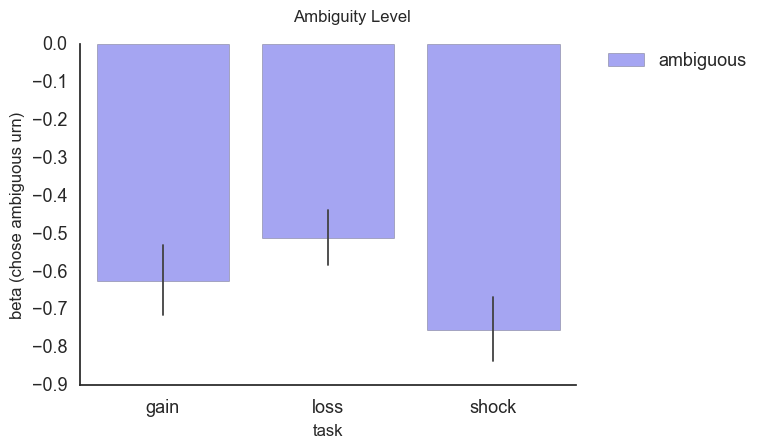

In [55]:
model_df = model_param_df.loc[model_param_df['parameter'] == 'ambiguityLevel']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Ambiguity Level', ylabel='beta (chose ambiguous urn)', xlabel='task', order=['ambiguous'], colors = ['blue'], widtherr = 1.3)


#### Gain as reference

In [56]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:              MixedLM Dependent Variable: beta    
No. Observations:   82      Method:             REML    
No. Groups:         28      Scale:              0.1334  
Min. group size:    1       Likelihood:         -49.8431
Max. group size:    3       Converged:          Yes     
Mean group size:    2.9                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.619    0.086 -7.171 0.000 -0.789 -0.450
task[T.loss]   0.113    0.099  1.135 0.256 -0.082  0.308
task[T.shock] -0.134    0.099 -1.351 0.177 -0.327  0.060
Intercept RE   0.069    0.108                           
========================================================

"""

#### Loss as reference

In [57]:
#tweak X, so that loss is the reference category instead of gain
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)

In [58]:
#run releveled model
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
========================================================
Model:              MixedLM Dependent Variable: beta    
No. Observations:   82      Method:             REML    
No. Groups:         28      Scale:              0.1334  
Min. group size:    1       Likelihood:         -49.8431
Max. group size:    3       Converged:          Yes     
Mean group size:    2.9                                 
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -0.507    0.086 -5.865 0.000 -0.676 -0.337
task[T.shock] -0.246    0.099 -2.492 0.013 -0.440 -0.053
task[T.gain]  -0.113    0.099 -1.135 0.256 -0.308  0.082
Intercept RE   0.069    0.108                           
========================================================

"""

#### shock as reference

In [59]:
#tweak X, so that shock is the reference category instead of gain
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)

In [60]:
#run releveled model
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
=======================================================
Model:             MixedLM Dependent Variable: beta    
No. Observations:  82      Method:             REML    
No. Groups:        28      Scale:              0.1334  
Min. group size:   1       Likelihood:         -49.8431
Max. group size:   3       Converged:          Yes     
Mean group size:   2.9                                 
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept    -0.753    0.085 -8.861 0.000 -0.919 -0.586
task[T.gain]  0.134    0.099  1.351 0.177 -0.060  0.327
task[T.loss]  0.246    0.099  2.492 0.013  0.053  0.440
Intercept RE  0.069    0.108                           
=======================================================

"""

### Task differences in ambiguity presence


#### Gain as reference

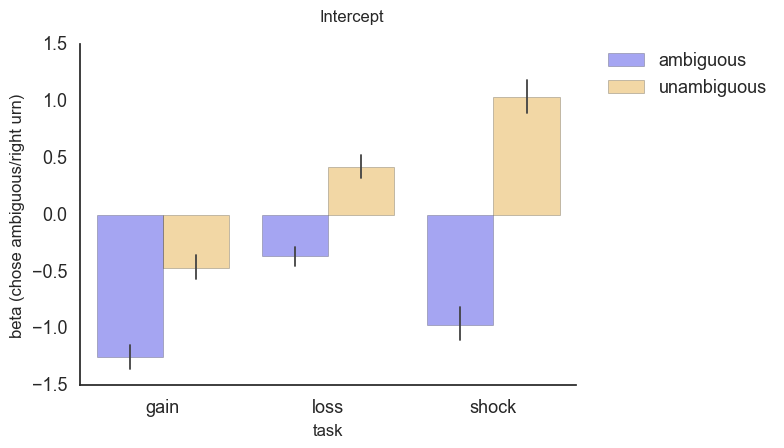

In [61]:
model_df = model_param_df.loc[model_param_df['parameter'] == 'intercept']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Intercept', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


In [62]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task + condition + task*condition', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

C:\Users\Hanna\Anaconda2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                       Mixed Linear Model Regression Results
==================================================================================
Model:                     MixedLM          Dependent Variable:          beta     
No. Observations:          164              Method:                      REML     
No. Groups:                28               Scale:                       0.3833   
Min. group size:           2                Likelihood:                  -159.6124
Max. group size:           6                Converged:                   Yes      
Mean group size:           5.9                                                    
----------------------------------------------------------------------------------
                                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------
Intercept                              -1.248    0.120 -10.386 0.000 -1.483 -1.012
task[T.loss]                            0.884    0.169   5.243 0.000  0.553  1.214
task[T.shock]                           0.284    0.167   1.697 0.090 -0.044  0.611
condition[T.unambiguous]                0.777    0.169   4.613 0.000  0.447  1.108
task[T.loss]:condition[T.unambiguous]   0.006    0.238   0.024 0.981 -0.461  0.473
task[T.shock]:condition[T.unambiguous]  1.225    0.236   5.186 0.000  0.762  1.688
Intercept RE                            0.006    0.035                            
==================================================================================

"""

#### Loss as reference

In [63]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0


In [64]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

C:\Users\Hanna\Anaconda2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         beta     
No. Observations:           164             Method:                     REML     
No. Groups:                 28              Scale:                      0.3833   
Min. group size:            2               Likelihood:                 -159.6124
Max. group size:            6               Converged:                  Yes      
Mean group size:            5.9                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                              -0.364    0.120 -3.031 0.002 -0.600 -0.129
task[T.shock]                          -0.600    0.167 -3.593 0.000 -0.927 -0.273
condition[T.unambiguous]                0.783    0.169  4.647 0.000  0.453  1.113
task[T.shock]:condition[T.unambiguous]  1.219    0.236  5.162 0.000  0.756  1.682
task[T.gain]                           -0.884    0.169 -5.244 0.000 -1.214 -0.553
task[T.gain]:condition[T.unambiguous]  -0.006    0.238 -0.023 0.981 -0.473  0.462
Intercept RE                            0.006    0.035                           
=================================================================================

"""

#### shock as reference

In [65]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [66]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

C:\Users\Hanna\Anaconda2\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1717: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
================================================================================
Model:                     MixedLM         Dependent Variable:         beta     
No. Observations:          164             Method:                     REML     
No. Groups:                28              Scale:                      0.3833   
Min. group size:           2               Likelihood:                 -159.6124
Max. group size:           6               Converged:                  Yes      
Mean group size:           5.9                                                  
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                             -0.964    0.118 -8.173 0.000 -1.195 -0.733
condition[T.unambiguous]               2.002    0.165 12.100 0.000  1.678  2.326
task[T.gain]                          -0.284    0.167 -1.698 0.090 -0.611  0.044
task[T.gain]:condition[T.unambiguous] -1.225    0.236 -5.186 0.000 -1.688 -0.762
task[T.loss]                           0.600    0.167  3.592 0.000  0.273  0.927
task[T.loss]:condition[T.unambiguous] -1.219    0.236 -5.162 0.000 -1.682 -0.756
Intercept RE                           0.006    0.035                           
================================================================================

"""

## Risk Preference Differences Across Tasks

### Magnitude

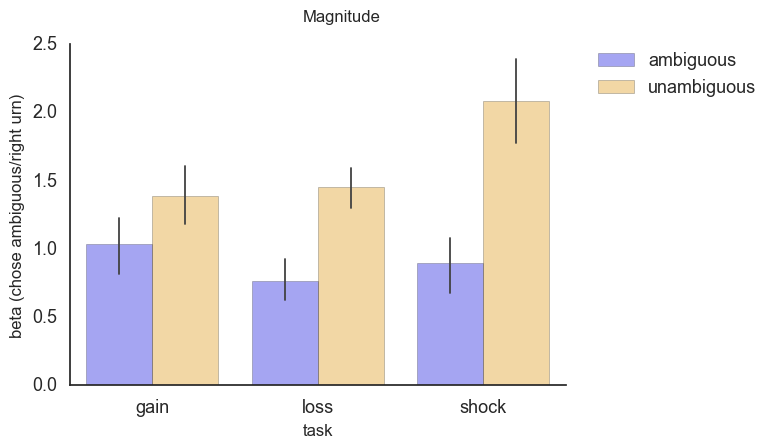

In [67]:
model_df = model_param_df
model_df = model_param_df.loc[model_param_df['parameter'] == 'mag_diff']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Magnitude', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


#### Gain as reference

In [68]:
#df.gain_or_loss_trial.astype('category')
y,X = dmatrices('beta ~ task + condition + task*condition ', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         beta     
No. Observations:           164             Method:                     REML     
No. Groups:                 28              Scale:                      0.8824   
Min. group size:            2               Likelihood:                 -241.4698
Max. group size:            6               Converged:                  Yes      
Mean group size:            5.9                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               1.034    0.217  4.769 0.000  0.609  1.459
task[T.loss]                           -0.276    0.256 -1.080 0.280 -0.777  0.225
task[T.shock]                          -0.138    0.254 -0.544 0.586 -0.636  0.359
condition[T.unambiguous]                0.351    0.256  1.372 0.170 -0.150  0.852
task[T.loss]:condition[T.unambiguous]   0.340    0.362  0.942 0.346 -0.368  1.049
task[T.shock]:condition[T.unambiguous]  0.837    0.358  2.336 0.019  0.135  1.539
Intercept RE                            0.393    0.176                           
=================================================================================

"""

#### Loss as reference

In [69]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0


In [70]:

model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         beta     
No. Observations:           164             Method:                     REML     
No. Groups:                 28              Scale:                      0.8824   
Min. group size:            2               Likelihood:                 -241.4698
Max. group size:            6               Converged:                  Yes      
Mean group size:            5.9                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               0.758    0.217  3.495 0.000  0.333  1.183
task[T.shock]                           0.138    0.254  0.543 0.587 -0.360  0.636
condition[T.unambiguous]                0.691    0.256  2.704 0.007  0.190  1.192
task[T.shock]:condition[T.unambiguous]  0.497    0.358  1.386 0.166 -0.205  1.199
task[T.gain]                            0.276    0.256  1.080 0.280 -0.225  0.777
task[T.gain]:condition[T.unambiguous]  -0.340    0.362 -0.941 0.347 -1.049  0.368
Intercept RE                            0.393    0.176                           
=================================================================================

"""

#### Shock as Reference

In [71]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [72]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
================================================================================
Model:                     MixedLM         Dependent Variable:         beta     
No. Observations:          164             Method:                     REML     
No. Groups:                28              Scale:                      0.8824   
Min. group size:           2               Likelihood:                 -241.4698
Max. group size:           6               Converged:                  Yes      
Mean group size:           5.9                                                  
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              0.896    0.213  4.196 0.000  0.477  1.314
condition[T.unambiguous]               1.188    0.251  4.733 0.000  0.696  1.680
task[T.gain]                           0.138    0.254  0.544 0.586 -0.359  0.636
task[T.gain]:condition[T.unambiguous] -0.837    0.358 -2.337 0.019 -1.539 -0.135
task[T.loss]                          -0.138    0.254 -0.543 0.587 -0.636  0.360
task[T.loss]:condition[T.unambiguous] -0.497    0.358 -1.387 0.166 -1.199  0.205
Intercept RE                           0.393    0.176                           
================================================================================

"""

### Probability

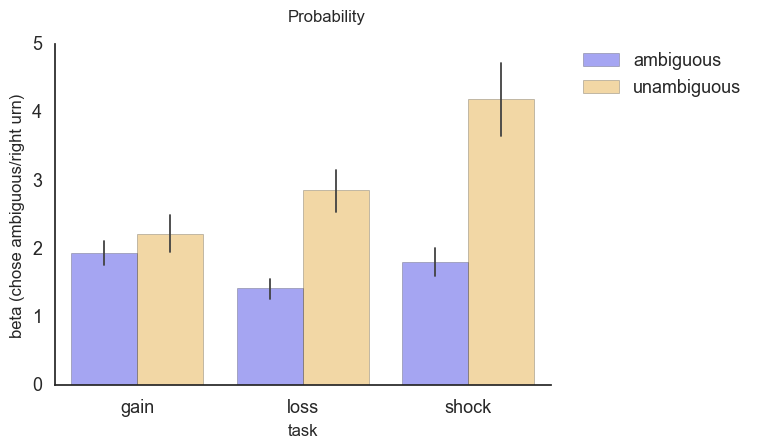

In [73]:
model_df = model_param_df
model_df = model_param_df.loc[model_param_df['parameter'] == 'prob_diff']
fig = plot_params(model_df,stripplot=False,outlier_cutoff=None, suptitle='Probability', ylabel='beta (chose ambiguous/right urn)', xlabel='task', order=['ambiguous', 'unambiguous'], colors = ['blue', 'orange'], widtherr = 1.3)


#### Gain as Reference

In [74]:
y,X = dmatrices('beta ~ task + condition + task*condition', data = model_df, return_type='dataframe')
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         beta     
No. Observations:           164             Method:                     REML     
No. Groups:                 28              Scale:                      2.0656   
Min. group size:            2               Likelihood:                 -305.7322
Max. group size:            6               Converged:                  Yes      
Mean group size:            5.9                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               1.905    0.318  5.992 0.000  1.282  2.528
task[T.loss]                           -0.512    0.391 -1.308 0.191 -1.278  0.255
task[T.shock]                          -0.094    0.388 -0.242 0.809 -0.855  0.667
condition[T.unambiguous]                0.280    0.391  0.717 0.474 -0.486  1.047
task[T.loss]:condition[T.unambiguous]   1.161    0.553  2.099 0.036  0.077  2.245
task[T.shock]:condition[T.unambiguous]  2.108    0.548  3.846 0.000  1.034  3.183
Intercept RE                            0.671    0.223                           
=================================================================================

"""

#### Loss as Reference

In [75]:
#relevel with loss as reference
X['task[T.gain]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.loss]'] == 0), 'task[T.gain]'] = 1.0
X = X.drop('task[T.loss]', axis=1)
X = X.drop('task[T.loss]:condition[T.unambiguous]', axis = 1)

X['task[T.gain]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.gain]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.gain]:condition[T.unambiguous]'] = 1.0

In [76]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
=================================================================================
Model:                      MixedLM         Dependent Variable:         beta     
No. Observations:           164             Method:                     REML     
No. Groups:                 28              Scale:                      2.0656   
Min. group size:            2               Likelihood:                 -305.7322
Max. group size:            6               Converged:                  Yes      
Mean group size:            5.9                                                  
---------------------------------------------------------------------------------
                                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------------------
Intercept                               1.393    0.318  4.382 0.000  0.770  2.016
task[T.shock]                           0.418    0.388  1.075 0.282 -0.344  1.179
condition[T.unambiguous]                1.441    0.391  3.685 0.000  0.675  2.208
task[T.shock]:condition[T.unambiguous]  0.947    0.548  1.728 0.084 -0.127  2.022
task[T.gain]                            0.512    0.391  1.309 0.191 -0.255  1.279
task[T.gain]:condition[T.unambiguous]  -1.161    0.553 -2.099 0.036 -2.245 -0.077
Intercept RE                            0.671    0.223                           
=================================================================================

"""

#### Shock as Reference

In [77]:
#relevel with shock as reference
X['task[T.loss]'] = 0
X.loc[(X['task[T.shock]'] == 0) & (X['task[T.gain]'] == 0), 'task[T.loss]'] = 1.0
X = X.drop('task[T.shock]', axis=1)
X = X.drop('task[T.shock]:condition[T.unambiguous]', axis = 1)

X['task[T.loss]:condition[T.unambiguous]'] = 0
X.loc[(X['task[T.loss]'] == 1) & (X['condition[T.unambiguous]'] == 1), 'task[T.loss]:condition[T.unambiguous]'] = 1.0


In [78]:
model = sm.MixedLM(y,X,model_df['MID']).fit()
model.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Mixed Linear Model Regression Results
================================================================================
Model:                     MixedLM         Dependent Variable:         beta     
No. Observations:          164             Method:                     REML     
No. Groups:                28              Scale:                      2.0656   
Min. group size:           2               Likelihood:                 -305.7322
Max. group size:           6               Converged:                  Yes      
Mean group size:           5.9                                                  
--------------------------------------------------------------------------------
                                      Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------
Intercept                              1.811    0.313  5.793 0.000  1.198  2.424
condition[T.unambiguous]               2.389    0.384  6.219 0.000  1.636  3.142
task[T.gain]                           0.094    0.388  0.242 0.809 -0.667  0.855
task[T.gain]:condition[T.unambiguous] -2.109    0.548 -3.846 0.000 -3.183 -1.034
task[T.loss]                          -0.418    0.388 -1.075 0.282 -1.179  0.344
task[T.loss]:condition[T.unambiguous] -0.948    0.548 -1.728 0.084 -2.022  0.127
Intercept RE                           0.671    0.223                           
================================================================================

"""

# Convert and save notebook as pdf

In [ ]:
#%%bash 
#jupyter nbconvert --to slides Clinical_DM_Learning_Rate_Difference_Anx_Dep.ipynb && mv Clinical_DM_Learning_Rate_Difference_Anx_Dep.slides.html Clinical_DM_Learning_Rate_Difference_Anx_Dep_v1.slides.html
#jupyter nbconvert --to html Example_analyze_emmas_fmri_shock_data.ipynb && mv Example_analyze_emmas_fmri_shock_data.html ../html_reports/Example_analyze_emmas_fmri_shock_data_v1.html
#jupyter nbconvert --to pdf --template pdf_template_nocode.tplx Basic_Analyses.ipynb

#cp Basic_Analyses.pdf ../reports/Basic_Analyses_12_13_2017.pdf
#cp Basic_Analyses.ipynb ../reports/Basic_Analyses_12_13_2017.ipynb